In [1]:
import tensorflow as tf

x = tf.Variable(3, name='x')
y = tf.Variable(4, name='y')
f = x*x*y + y + 2

In [2]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)
sess.close()

42


In [7]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()
    print(result)

42


In [41]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    #init.run() # initialize all variables
    sess.run(init)
    result = f.eval()
    print(result)

42


In [9]:
sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)
sess.close()

42


In [10]:
x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [11]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)

x2.graph is graph

True

In [12]:
x2.graph is tf.get_default_graph()

False

In [13]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())
    print(z.eval())

10
15


In [15]:
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)
    print(z_val)

10
15


# Normal Equation for Linear Regression

In [2]:
import numpy as np
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()
    print(theta_value)

[[ -3.74651413e+01]
 [  4.35734153e-01]
 [  9.33829229e-03]
 [ -1.06622010e-01]
 [  6.44106984e-01]
 [ -4.25131839e-06]
 [ -3.77322501e-03]
 [ -4.26648885e-01]
 [ -4.40514028e-01]]


In [5]:
housing.data.shape

(20640, 8)

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [32]:
scaled_housing_data_plus_bias[0:2]

array([[ 1.        ,  2.34476576,  0.98214266,  0.62855945, -0.15375759,
        -0.9744286 , -0.04959654,  1.05254828, -1.32783522],
       [ 1.        ,  2.33223796, -0.60701891,  0.32704136, -0.26333577,
         0.86143887, -0.09251223,  1.04318455, -1.32284391]])

# Gradient Descent and save model

In [14]:
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n+1, 1], -1., 1.), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

# Original way
#gradients = 2/m * tf.matmul(tf.transpose(X), error)
#training_op = tf.assign(theta, theta - learning_rate * gradients)

# Use autodiff to compute gradients automatically
#gradients = tf.gradients(mse, [theta])[0]
#training_op = tf.assign(theta, theta - learning_rate * gradients)

# Use an Optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
#optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch = ", epoch, "MSE = ", mse.eval())
            save_path = saver.save(sess, "C:\Boyuan\MyPython\HandsOnML\\tmp\\my_model.ckpt")
        sess.run(training_op)  #the same as training_op.eval()
        
    best_theta = theta.eval()
    print(best_theta)
    save_path = saver.save(sess, "C:\Boyuan\MyPython\HandsOnML\\tmp\\my_model_final.ckpt")

Epoch =  0 MSE =  4.92846


Epoch =  100 MSE =  0.694995


Epoch =  200 MSE =  0.592247


Epoch =  300 MSE =  0.574755


Epoch =  400 MSE =  0.563695


Epoch =  500 MSE =  0.555321
Epoch = 

 600 MSE =  0.548853
Epoch =  700 MSE =  0.543827


Epoch =  800 MSE =  0.539899
Epoch =  900 MSE =  0.536814


[[ 2.06855249]
 [ 0.70124704]
 [ 0.11370201]
 [ 0.01258701]
 [ 0.06007489]
 [-0.00467434]
 [-0.03616179]
 [-1.05723464]
 [-1.01122832]]


# Restore model

In [22]:
import numpy as np
from sklearn.datasets import fetch_california_housing

tf.reset_default_graph()

housing = fetch_california_housing()
m, n = housing.data.shape

theta = tf.get_variable(shape=[n+1, 1], name="theta")
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "C:\Boyuan\MyPython\HandsOnML\\tmp\\my_model_final.ckpt")
    best_theta = theta.eval()
    print(best_theta)


INFO:tensorflow:Restoring parameters from C:\Boyuan\MyPython\HandsOnML\tmp\my_model_final.ckpt


[[ 2.06855249]
 [ 0.70124704]
 [ 0.11370201]
 [ 0.01258701]
 [ 0.06007489]
 [-0.00467434]
 [-0.03616179]
 [-1.05723464]
 [-1.01122832]]


# Mini batch gradient descent by me 

In [5]:
y_train = housing.target.reshape(-1, 1)

In [6]:
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch*n_batches + batch_index)
    random_index = np.random.choice(m, batch_size, replace=False)  # or use indices = np.random.randint(m, size=batch_size)
    X_batch = scaled_housing_data_plus_bias[random_index]
    y_batch = y_train[random_index]
    return X_batch, y_batch

In [39]:
n_epochs = 1000
learning_rate = 0.005
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

theta = tf.Variable(tf.random_uniform([n+1, 1], -1., 1.), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

#gradients = 2/m * tf.matmul(tf.transpose(X), error)
#training_op = tf.assign(theta, theta - learning_rate * gradients)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()


with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        #print("Epoch = ", epoch)
        if epoch % 100 == 0:
            print("Epoch = ", epoch, "MSE = ", mse.eval(feed_dict={X: scaled_housing_data_plus_bias, y: y_train}))
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            #if epoch % 100 == 0 and batch_index % 10 == 0 :
            #    print("Epoch = ", epoch, "batch_index = ", batch_index, "MSE = ", mse.eval(feed_dict={X: X_batch, y: y_batch}))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
    best_theta = theta.eval()
    print(best_theta)



Epoch =  0 batch_index =  70 MSE =  11.5307


Epoch =  100 batch_index =  206 MSE =  0.526935


Epoch =  200 batch_index =  206 MSE =  0.527735


Epoch =  300 batch_index =  206 MSE =  0.526361


Epoch =  400 batch_index =  206 MSE =  0.527272


KeyboardInterrupt: 

# Mini batch gradient descent from Book

In [40]:
n_epochs = 1000
learning_rate = 0.005
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
    indices = np.random.randint(m, size=batch_size)  # not shown
    X_batch = scaled_housing_data_plus_bias[indices] # not shown
    y_batch = housing.target.reshape(-1, 1)[indices] # not shown
    return X_batch, y_batch

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch = ", epoch, "MSE = ", mse.eval(feed_dict={X: scaled_housing_data_plus_bias, y: y_train}))
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

Epoch =  0 MSE =  4.37194


Epoch =  100 MSE =  0.533823


Epoch =  200 MSE =  0.525401


Epoch =  300 MSE =  0.529582


Epoch =  400 MSE =  0.524672


Epoch =  500 MSE =  0.52812


Epoch =  600 MSE =  0.524793


KeyboardInterrupt: 

# Save and restore model

In [ ]:
# Create some variables.
v1 = tf.get_variable("v1", shape=[3], initializer = tf.zeros_initializer)
v2 = tf.get_variable("v2", shape=[5], initializer = tf.zeros_initializer)

inc_v1 = v1.assign(v1+1)
dec_v2 = v2.assign(v2-1)

# Add an op to initialize the variables.
init_op = tf.global_variables_initializer()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, initialize the variables, do some work, and save the
# variables to disk.
with tf.Session() as sess:
  sess.run(init_op)
  # Do some work with the model.
  inc_v1.op.run()
  dec_v2.op.run()
  # Save the variables to disk.
  save_path = saver.save(sess, "C:\Boyuan\MyPython\HandsOnML\\tmp\\simple_model.ckpt")
  print("Model saved in file: %s" % save_path)

In [18]:
tf.reset_default_graph()

# Create some variables.
v1 = tf.get_variable("v1", shape=[3])
v2 = tf.get_variable("v2", shape=[5])

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
  # Restore variables from disk.
  saver.restore(sess, "C:\Boyuan\MyPython\HandsOnML\\tmp\\simple_model.ckpt")
  print("Model restored.")
  # Check the values of the variables
  print("v1 : %s" % v1.eval())
  print("v2 : %s" % v2.eval())

INFO:tensorflow:Restoring parameters from C:\Boyuan\MyPython\HandsOnML\tmp\simple_model.ckpt


Model restored.
v1 : [ 1.  1.  1.]
v2 : [-1. -1. -1. -1. -1.]


## Write MSE and step to log, and be able to show graph by tensorboard

In [8]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "C:\Boyuan\MyPython\HandsOnML\\{}\\run-{}\\".format(root_logdir, now)

n_epochs = 10
learning_rate = 0.005
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

theta = tf.Variable(tf.random_uniform([n+1, 1], -1., 1.), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())  # or file_writer = tf.summary.FileWriter(logdir, sess.graph) 

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 ==0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
    best_theta = theta.eval()
    print(best_theta)

file_writer.close()

[[ 2.06752419]
 [ 0.86637586]
 [ 0.14600717]
 [-0.27849847]
 [ 0.35490558]
 [ 0.0070019 ]
 [-0.04934338]
 [-0.68228167]
 [-0.65818912]]


In [31]:
tf.get_default_graph()

In [9]:
print(error.op.name)

loss/sub


In [10]:
print(mse.op.name)

loss/mse


## Modularity

In [24]:
tf.reset_default_graph()

def relu(X):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, 0., name="relu")

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

## Sharing Variables using get_variable method 1

In [26]:
tf.reset_default_graph()

def relu(X):
    with tf.variable_scope("relu", reuse=True):
        threshold = tf.get_variable("threshold")  #reuse existing variable
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, threshold, name="relu")

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("relu"):  #create the variable
    threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

## Sharing Variables using get_variable method 2

In [31]:
tf.reset_default_graph()

def relu(X):
    threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.random_normal(w_shape), name="weights")
    b = tf.Variable(0.0, name="bias")
    z = tf.add(tf.matmul(X, w), b, name="z")
    return tf.maximum(z, threshold, name="relu")

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = []
for relu_index in range(5):
    with tf.variable_scope("relu", reuse=(relu_index > 0)) as scope:
        relus.append(relu(X))
output = tf.add_n(relus, name="output")

In [32]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "C:\Boyuan\MyPython\HandsOnML\\{}\\run-{}\\".format(root_logdir, now)

init = tf.global_variables_initializer()

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph()) 

with tf.Session() as sess:
    sess.run(init)
    output_val = output.eval(feed_dict={X: [[1, 2, 3], [4, 5, 6]]})

file_writer.close()
print(output_val)

[[ 11.85008621]
 [ 19.41698456]]


## Batch Gradient Descent Logistic Regression

In [270]:
from sklearn import datasets
iris = datasets.load_iris()
iris_data_X = iris["data"][:]
iris_data_y = (iris["target"] == 2).astype(np.int)  # 1 if Iris-Virginica, else 0
feature_length = iris_data_X.shape[1]
data_num = iris_data_X.shape[0]
iris_data_y = iris_data_y.reshape(-1, 1)

In [40]:
iris_data_y[0:5]

array([[0],
       [0],
       [0],
       [0],
       [0]])

In [271]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_iris_data = scaler.fit_transform(iris_data_X)
scaled_iris_data_plus_bias = np.c_[np.ones((data_num, 1)), scaled_iris_data]

In [34]:
scaled_iris_data_plus_bias[0:5]

array([[ 1.        , -0.90068117,  1.03205722, -1.3412724 , -1.31297673],
       [ 1.        , -1.14301691, -0.1249576 , -1.3412724 , -1.31297673],
       [ 1.        , -1.38535265,  0.33784833, -1.39813811, -1.31297673],
       [ 1.        , -1.50652052,  0.10644536, -1.2844067 , -1.31297673],
       [ 1.        , -1.02184904,  1.26346019, -1.3412724 , -1.31297673]])

In [55]:
iris_data_y.shape

(150, 1)

In [56]:
scaled_iris_data_plus_bias.shape

(150, 5)

In [272]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=None)
for train_index, test_index in split.split(scaled_iris_data_plus_bias, iris_data_y):
    iris_train_data = scaled_iris_data_plus_bias[train_index]
    iris_train_target = iris_data_y[train_index]
    iris_test_data = scaled_iris_data_plus_bias[test_index]
    iris_test_target = iris_data_y[test_index]

In [273]:
np.count_nonzero(iris_train_target == 0) / len(iris_train_target)

0.6666666666666666

In [274]:
np.count_nonzero(iris_test_target == 0) / len(iris_test_target)

0.6666666666666666

In [121]:
test_index

array([133, 137,  62, 113, 120, 127,  84,  45, 148,   2,  90, 131,  71,
       116,  40, 147,  41,  93,  35,  16,  51, 139,  21,  14,  33,  69,
        24, 140, 117,  87, 111, 121,  80,  58,  48,   8, 109,  13,  82,
        47,  85,   9,  29,  79,  50], dtype=int64)

In [130]:
iris_train_data[0:2]

array([[ 1.        ,  0.91683689, -0.1249576 ,  0.36469871,  0.26469891],
       [ 1.        ,  1.03800476,  0.10644536,  0.53529583,  0.39617188]])

In [131]:
n_epochs = 50000
learning_rate = 0.5

X = tf.placeholder(tf.float32, shape=(None, feature_length + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

#one = tf.constant(1.0, shape=[data_num, 1], dtype=tf.float32, name="one")

theta = tf.Variable(tf.random_uniform([feature_length+1, 1], -1., 1.), name="theta")
h = 1 / (1 + tf.exp(-tf.matmul(X, theta, name="h")))

with tf.name_scope("loss") as scope:
    loss = - tf.matmul(tf.transpose(y), tf.log(h + 1e-10)) - tf.matmul(tf.transpose(1 - y), tf.log(1 - h + 1e-10))
    loss_avg = loss / data_num

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss_avg)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    '''
    loss_eval, loss_avg_eval = sess.run([loss, loss_avg], feed_dict={X: scaled_iris_data_plus_bias, y: iris_data_y})
    #result = log.eval(feed_dict={X: scaled_iris_data_plus_bias, y: iris_data_y})
    #result = log.eval(feed_dict={X: scaled_iris_data_plus_bias, y: iris_data_y})
    print(loss_eval, loss_avg_eval) 
    '''
    
    for epoch in range(n_epochs):
        if epoch % 2000 == 0:
            print("Epoch = ", epoch, "loss_avg = ", loss_avg.eval(feed_dict={X: iris_train_data, y: iris_train_target}))
        sess.run(training_op, feed_dict={X: iris_train_data, y: iris_train_target})  #the same as training_op.eval()
        
    best_theta = theta.eval()
    print(best_theta)

Epoch =  0 loss_avg =  [[ 0.9758786]]


Epoch =  2000 loss_avg =  [[ 0.03956911]]


Epoch =  4000 loss_avg =  [[ 0.03143882]]


Epoch =  6000 loss_avg =  [[ 0.02793766]]


Epoch =  8000 loss_avg =  [[ 0.02586797]]


Epoch =  10000 loss_avg =  [[ 0.02445231]]


Epoch =  12000 loss_avg =  [[ 0.02339782]]


Epoch =  14000 loss_avg =  [[ 0.02256728]]


Epoch =  16000 loss_avg =  [[ 0.02188688]]


Epoch =  18000 loss_avg =  [[ 0.02131313]]


Epoch =  20000 loss_avg =  [[ 0.02081847]]


Epoch =  22000 loss_avg =  [[ 0.02038449]]


Epoch =  24000 loss_avg =  [[ 0.01999837]]


Epoch =  26000 loss_avg =  [[ 0.01965084]]


Epoch =  28000 loss_avg =  [[ 0.01933502]]


Epoch =  30000 loss_avg =  [[ 0.01904564]]


Epoch =  32000 loss_avg =  [[ 0.01877876]]


Epoch =  34000 loss_avg =  [[ 0.01853107]]


Epoch =  36000 loss_avg =  [[ 0.01830011]]


Epoch =  38000 loss_avg =  [[ 0.01808346]]


Epoch =  40000 loss_avg =  [[ 0.01787954]]


Epoch =  42000 loss_avg =  [[ 0.01768712]]


Epoch =  44000 loss_avg =  [[ 0.01750462]]


Epoch =  46000 loss_avg =  [[ 0.01733118]]


Epoch =  48000 loss_avg =  [[ 0.01716599]]


[[-18.44579506]
 [ -2.40257573]
 [ -2.43487763]
 [ 19.20875359]
 [ 10.13577271]]


In [132]:
X = tf.placeholder(tf.float32, shape=(None, feature_length + 1), name="X")
h = (1 / (1 + tf.exp(-tf.matmul(X, best_theta, name="h")))) > 0.5

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    result = (h.eval(feed_dict={X: iris_test_data})).astype(np.int)
    print(result)

[[0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]]


In [133]:
from sklearn.metrics import precision_score, recall_score
precision_score(iris_test_target, result)

0.9375

In [134]:
recall_score(iris_test_target, result)

1.0

## Update the training and predict as function 

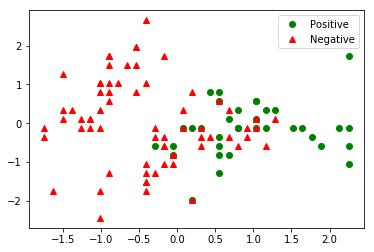

In [303]:
import matplotlib.pyplot as plt
iris_train_target_array = iris_train_target.reshape(-1)
plt.plot(iris_train_data[iris_train_target_array == 1, 1], iris_train_data[iris_train_target_array == 1, 2], 'go', label="Positive")
plt.plot(iris_train_data[iris_train_target_array == 0, 1], iris_train_data[iris_train_target_array == 0, 2], 'r^', label="Negative")
plt.legend()
plt.show()

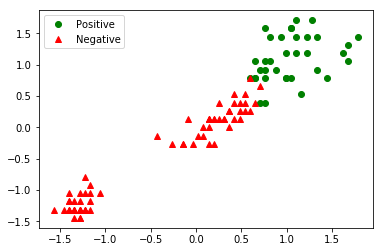

In [309]:
plt.plot(iris_train_data[iris_train_target_array == 1, 3], iris_train_data[iris_train_target_array == 1, 4], 'go', label="Positive")
plt.plot(iris_train_data[iris_train_target_array == 0, 3], iris_train_data[iris_train_target_array == 0, 4], 'r^', label="Negative")
plt.legend()
plt.show()

In [136]:
def logistic_regression_train(n_epochs, learning_rate, train_data, train_target):
    X = tf.placeholder(tf.float32, shape=(None, feature_length + 1), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

    theta = tf.Variable(tf.random_uniform([feature_length+1, 1], -1., 1.), name="theta")
    h = 1 / (1 + tf.exp(-tf.matmul(X, theta, name="h")))

    with tf.name_scope("loss") as scope:
        loss = - tf.matmul(tf.transpose(y), tf.log(h + 1e-10)) - tf.matmul(tf.transpose(1 - y), tf.log(1 - h + 1e-10))
        loss_avg = loss / data_num

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss_avg)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(n_epochs):
            if epoch % 2000 == 0:
                print("Epoch = ", epoch, "loss_avg = ", loss_avg.eval(feed_dict={X: iris_train_data, y: iris_train_target}))
            sess.run(training_op, feed_dict={X: train_data, y: train_target})  #the same as training_op.eval()
        best_theta = theta.eval()
        return best_theta

In [290]:
tf.reset_default_graph()

In [291]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "C:\Boyuan\MyPython\HandsOnML\\{}\\run-{}\\".format(root_logdir, name)

In [292]:
def logistic_regression(feature_length, X, y, learning_rate = 0.1):
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            theta = tf.Variable(tf.random_uniform([feature_length+1, 1], -1., 1.), name="theta")
            logits = tf.matmul(X, theta, name="logits")
            h = tf.sigmoid(logits, name="h")  # h = 1 / (1 + tf.exp(-tf.matmul(X, theta, name="h")))
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, h, scope="loss")  # loss = - tf.matmul(tf.transpose(y), tf.log(h + 1e-10)) - tf.matmul(tf.transpose(1 - y), tf.log(1 - h + 1e-10))
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
    return h, loss, training_op, loss_summary, init, theta

In [293]:
X = tf.placeholder(tf.float32, shape=(None, feature_length + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
n_epochs = 10000
learning_rate = 0.5
h, loss, training_op, loss_summary, init, theta = logistic_regression(feature_length, X, y, learning_rate)
logdir = log_dir("mylogreg")
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

with tf.Session() as sess:
        sess.run(init)
        for epoch in range(n_epochs):
            if epoch % 2000 == 0:
                print("Epoch = ", epoch, "loss = ", loss.eval(feed_dict={X: iris_train_data, y: iris_train_target}))
            sess.run(training_op, feed_dict={X: iris_train_data, y: iris_train_target})  #the same as training_op.eval()
            file_writer.add_summary(summary_str, epoch)
        best_theta = theta.eval()
        test_predict = h.eval(feed_dict={X: iris_test_data})
        
file_writer.close()

Epoch =  0 loss =  0.907659


Epoch =  2000 loss =  0.04232


Epoch =  4000 loss =  0.032415


Epoch =  6000 loss =  0.0276956


Epoch =  8000 loss =  0.0246715


In [294]:
test_predict = (test_predict > 0.5)
precision_score(iris_test_target, test_predict)

0.83333333333333337

In [295]:
recall_score(iris_test_target, test_predict)

1.0

## Logistic Regression with Mini-Batch Gradient Descent using TensorFlow from Book

In [144]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

In [146]:
X_moons[0:5]

array([[-0.05146968,  0.44419863],
       [ 1.03201691, -0.41974116],
       [ 0.86789186, -0.25482711],
       [ 0.288851  , -0.44866862],
       [-0.83343911,  0.53505665]])

In [153]:
y_moons[0:5]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1,

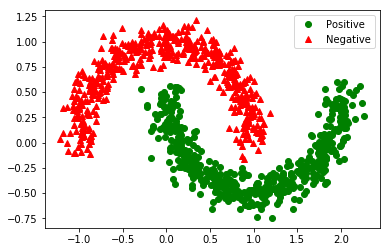

In [149]:
import matplotlib.pyplot as plt
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

In [150]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]

In [151]:

X_moons_with_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

In [152]:
y_moons_column_vector = y_moons.reshape(-1, 1)

In [154]:
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

In [155]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [156]:
X_batch, y_batch = random_batch(X_train, y_train, 5)
X_batch

array([[ 1.        ,  1.74558183, -0.12250168],
       [ 1.        ,  0.67427553, -0.46780743],
       [ 1.        , -0.63175131,  0.93849495],
       [ 1.        ,  0.57510237, -0.39518195],
       [ 1.        ,  0.21408172, -0.07499009]])

In [157]:
y_batch

array([[1],
       [1],
       [0],
       [1],
       [1]], dtype=int64)

In [159]:
tf.reset_default_graph()

In [160]:
n_inputs = 2

In [233]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42),name="theta")
logits = tf.matmul(X, theta, name="logits")
y_proba = tf.sigmoid(logits)   # y_proba = 1 / (1 + tf.exp(-logits))

In [234]:
epsilon = 1e-7  # to avoid an overflow when computing the log
loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1 - y_proba + epsilon))

In [235]:
loss = tf.losses.log_loss(y, y_proba)  # uses epsilon = 1e-7 by default

In [236]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [238]:
init = tf.global_variables_initializer()
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.875004


Epoch: 100 	Loss: 0.351406


Epoch: 200 	Loss: 0.310777


Epoch: 300 	Loss: 0.294868


Epoch: 400 	Loss: 0.286126


Epoch: 500 	Loss: 0.280987


Epoch: 600 	Loss: 0.278394


Epoch: 700 	Loss: 0.276503


Epoch: 800 	Loss: 0.275567


Epoch: 900 	Loss: 0.274876


In [239]:
y_proba_val[:5]

array([[ 0.54407722],
       [ 0.70325011],
       [ 0.51412779],
       [ 0.99085742],
       [ 0.50398284]], dtype=float32)

In [240]:
y_pred = (y_proba_val >= 0.5)
y_pred[:5]

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True]], dtype=bool)

In [241]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

0.86138613861386137

In [242]:
recall_score(y_test, y_pred)

0.87878787878787878

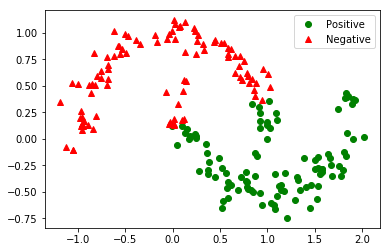

In [243]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

In [244]:
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

In [245]:
X_train_enhanced[:5]

array([[  1.00000000e+00,  -5.14696757e-02,   4.44198631e-01,
          2.64912752e-03,   1.97312424e-01,  -1.36349734e-04,
          8.76459084e-02],
       [  1.00000000e+00,   1.03201691e+00,  -4.19741157e-01,
          1.06505890e+00,   1.76182639e-01,   1.09915879e+00,
         -7.39511049e-02],
       [  1.00000000e+00,   8.67891864e-01,  -2.54827114e-01,
          7.53236288e-01,   6.49368582e-02,   6.53727646e-01,
         -1.65476722e-02],
       [  1.00000000e+00,   2.88850997e-01,  -4.48668621e-01,
          8.34348982e-02,   2.01303531e-01,   2.41002535e-02,
         -9.03185778e-02],
       [  1.00000000e+00,  -8.33439108e-01,   5.35056649e-01,
          6.94620746e-01,   2.86285618e-01,  -5.78924095e-01,
          1.53179024e-01]])

In [247]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [252]:
reset_graph()

In [253]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

In [255]:
n_inputs = 2 + 4
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [259]:
import os

n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "C:\\Boyuan\\MyPython\\HandsOnML\\model_tmp\\my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "C:\\Boyuan\\MyPython\\HandsOnML\\model_final\\my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.6287


Epoch: 500 	Loss: 0.161268


Epoch: 1000 	Loss: 0.119042


Epoch: 1500 	Loss: 0.0973036


Epoch: 2000 	Loss: 0.083746


Epoch: 2500 	Loss: 0.0743773


Epoch: 3000 	Loss: 0.0675237


Epoch: 3500 	Loss: 0.0622342


Epoch: 4000 	Loss: 0.0580196


Epoch: 4500 	Loss: 0.0545912


Epoch: 5000 	Loss: 0.0517089


Epoch: 5500 	Loss: 0.0493017


Epoch: 6000 	Loss: 0.0472196


Epoch: 6500 	Loss: 0.0453759


Epoch: 7000 	Loss: 0.0437689


Epoch: 7500 	Loss: 0.0423425


Epoch: 8000 	Loss: 0.0410767


Epoch: 8500 	Loss: 0.039938


Epoch: 9000 	Loss: 0.0389135


Epoch: 9500 	Loss: 0.0379921


Epoch: 10000 	Loss: 0.0371298


In [260]:
y_pred = (y_proba_val >= 0.5)

In [261]:
precision_score(y_test, y_pred)

0.97979797979797978

In [262]:

recall_score(y_test, y_pred)

0.97979797979797978

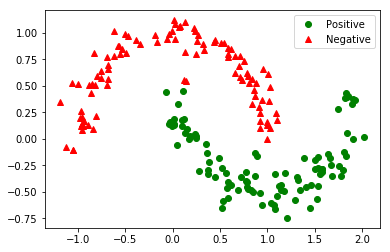

In [263]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

## A test for Python scalar multiplication, dot product and matrix multiply

In [228]:
X = np.array([[0], [1], [2]])
y = np.array([[0], [1], [2]])
y_2 = np.array([[0, 1, 2]])
z = X * y
q = X.dot(y_2)
p = X * y_2
#m = X.dot(y)
n = 3 * X
h = 3 * p
j = 1 / p
k = X + y
l = p + q

C:\Users\boyuan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [209]:
X.shape

(3, 1)

In [206]:
y_2.shape

(1, 3)

In [207]:
z

array([[0],
       [1],
       [4]])

In [208]:
q

array([[0, 0, 0],
       [0, 1, 2],
       [0, 2, 4]])

In [212]:
p

array([[0, 0, 0],
       [0, 1, 2],
       [0, 2, 4]])

In [221]:
n

array([[0],
       [3],
       [6]])

In [223]:
h

array([[ 0,  0,  0],
       [ 0,  3,  6],
       [ 0,  6, 12]])

In [225]:
j

array([[  inf,   inf,   inf],
       [  inf,  1.  ,  0.5 ],
       [  inf,  0.5 ,  0.25]])

In [227]:
k

array([[0],
       [2],
       [4]])

In [229]:
l

array([[0, 0, 0],
       [0, 2, 4],
       [0, 4, 8]])